The command installs Python packages for NLP and dataset management, evaluation tools, and 7z archive handling with the '-q' flag for quiet installation.

In [5]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

The command "!nvidia-smi" is used to display information about NVIDIA GPU status and usage.

In [6]:
!nvidia-smi

Fri Nov 24 14:34:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The code imports various Python libraries, including the Hugging Face Transformers library, Matplotlib, datasets, NLTK for text processing, and sets up the environment for sequence-to-sequence language modeling.

In [9]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio -U

Found existing installation: torch 2.1.1
Uninstalling torch-2.1.1:
  Successfully uninstalled torch-2.1.1
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
  Using cached torch-2.1.1-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached torchvision-0.16.1-cp310-cp310-manylinux1_x86_64.whl (6.8 MB)
  Using cached torchaudio-2.1.1-cp310-cp310-manylinux1_x86_64.whl (3.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.


In [1]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch
nltk.download("punkt")
!pip install transformers -U
!pip install accelerate -U

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The code initializes a sequence-to-sequence model using the "google/pegasus-cnn_dailymail" checkpoint and sets the device to GPU if available, otherwise to CPU.

In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This function splits a list of elements into smaller batches for simultaneous processing.

In [3]:
def create_data_batches(list_of_elements, batch_size):
    """Split the dataset into smaller batches for simultaneous processing.
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

This function calculates ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores on a test dataset using a pre-trained language model for summarization and specified tokenizer. It processes the data in batches and returns the computed ROUGE scores.

In [4]:
def evaluate_model_metric(test_data, evaluation_metric, text_model, text_tokenizer,
                           batch_size=16, device=device,
                           text_column="article",
                           summary_column="highlights"):
    text_batches = list(create_data_batches(test_data[text_column], batch_size))
    target_batches = list(create_data_batches(test_data[summary_column], batch_size))

    for text_batch, target_batch in tqdm(
        zip(text_batches, target_batches), total=len(text_batches)):
        inputs = text_tokenizer(text_batch, max_length=1024, truncation=True,
                                padding="max_length", return_tensors="pt")

        summaries = text_model.generate(input_ids=inputs["input_ids"].to(device),
                                       attention_mask=inputs["attention_mask"].to(device),
                                       length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [text_tokenizer.decode(s, skip_special_tokens=True,
                                                   clean_up_tokenization_spaces=True)
                             for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        evaluation_metric.add_batch(predictions=decoded_summaries, references=target_batch)

    computed_score = evaluation_metric.compute()
    return computed_score


### Load data

Link: https://huggingface.co/datasets/samsum

This code loads the "samsum" dataset, prints the lengths of dataset splits, displays the available features, and shows a dialogue and its corresponding summary from the test split.

In [5]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][1]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][1]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


# Evaluating PEGASUS on SAMSum


This code accesses the dialogue from the "samsum" dataset's test split at index 0.

In [6]:
dataset_samsum['test'][4]['dialogue']

'Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the  18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar..  thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean " we don\'t have any more whisky!" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what\'s wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont\' worry, we\'ll check on friday.\r\nOllie: don\'t forget to bring some sun with you\r\nJane: I can\'t wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i\'m very busy, i won\'t have time for lunch  tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: 

This code uses the Hugging Face Transformers library to generate a summary of the dialogue using the "google/pegasus-cnn_dailymail" model and prints the summary.


In [7]:
pipe = pipeline('summarization', model = model_ckpt )
pipe_out = pipe(dataset_samsum['test'][4]['dialogue'] )
print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'summary_text': "Ollie calls Jane to ask if she has any more whisky .<n>Jane is worried that Ollie has a spy in his mobile phone .<n>The pair discuss Jane's upcoming trip to Morocco ."}]


This code prints the generated summary by accessing the "summary_text" field from the `pipe_out` result and replaces "<n>" with a newline character to format it properly.


In [8]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Ollie calls Jane to ask if she has any more whisky.
Jane is worried that Ollie has a spy in his mobile phone.
The pair discuss Jane's upcoming trip to Morocco .


This code loads the ROUGE metric, calculates ROUGE scores on the "samsum" dataset's test split using a Pegasus model for summarization and a specified tokenizer. The calculated scores are stored in the 'score' variable.

In [9]:
rouge_metric = load_metric('rouge')
score = evaluate_model_metric(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, text_column = 'dialogue', summary_column='summary', batch_size=8)

<ipython-input-9-a2af470ab8ec>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
100%|██████████| 103/103 [19:15<00:00, 11.21s/it]


This code computes ROUGE scores for "rouge1," "rouge2," "rougeL," and "rougeLsum" on a summarization model's output and creates a Pandas DataFrame with these scores, labeled under the 'pegasus' index.

In [10]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015529,0.000294,0.015501,0.015531


# Histogram


This code calculates the token lengths for both dialogue and summary texts in the training dataset and creates two histograms to visualize the token length distributions. The left histogram represents dialogue token lengths, and the right histogram represents summary token lengths. The plots provide insights into the distribution of token lengths in the dataset.

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


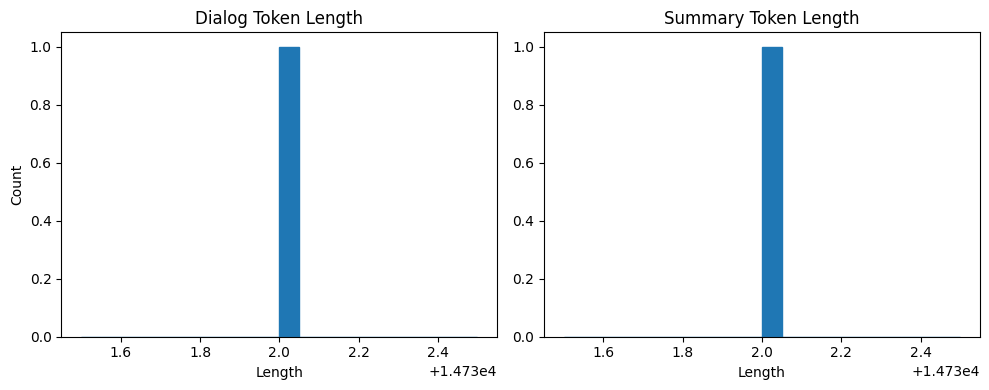

In [11]:
dialog_token_lengths = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])
sum_token_lengths = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialog_token_lengths, bins=20, color='C0', edgecolor='C0')
axes[0].set_title("Dialog Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(sum_token_lengths, bins=20, color='C0', edgecolor='C0')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

This code defines a function, `preprocess_data_batch`, to convert example batches into tokenized features for dialogue and summary texts. It utilizes the Hugging Face Transformers tokenizer to preprocess the data. The resulting processed dataset is stored in `dataset_samsum_pt`, which is batched for further use in training or evaluation.

In [12]:
def preprocess_data_batch(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length=128, truncation=True)

    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(preprocess_data_batch, batched=True)


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


This code initializes a data collator specifically designed for sequence-to-sequence tasks using the Hugging Face Transformers library. It is configured to work with the Pegasus model and tokenizer.

In [13]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

This code mounts Google Drive to the '/content/drive' directory in a Google Colab environment.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This command changes the current directory to 'MyDrive' in the Google Drive directory mounted in a Google Colab environment.

In [15]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


This code defines training arguments for a transformer model using the Hugging Face Transformers library, specifying parameters such as output directory, training duration, batch sizes, evaluation settings, and logging intervals.

In [16]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.24.1')

In [17]:
from transformers import TrainingArguments, Trainer
trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

This code sets up a trainer for fine-tuning a Pegasus model on a summarization task, configuring the model, training arguments, tokenizer, data collator, and training and evaluation datasets.

In [18]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

This code initiates the training process for the configured model using the specified trainer.

In [19]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.626500,1.484255


TrainOutput(global_step=920, training_loss=1.8238315105438232, metrics={'train_runtime': 2819.5526, 'train_samples_per_second': 5.225, 'train_steps_per_second': 0.326, 'total_flos': 5526698901602304.0, 'train_loss': 1.8238315105438232, 'epoch': 1.0})

This code calculates ROUGE scores for a test dataset using a fine-tuned Pegasus model and then creates a Pandas DataFrame with the computed ROUGE scores, labeled under 'pegasus'.

In [20]:
score = evaluate_model_metric(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, text_column = 'dialogue', summary_column= 'summary'
)
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 410/410 [13:54<00:00,  2.04s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018575,0.000325,0.018426,0.018444


This code saves the fine-tuned Pegasus model to the directory "pegasus-samsum-model."

In [21]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

This code saves the tokenizer associated with the fine-tuned Pegasus model to the "tokenizer" directory.

In [22]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

This code loads the "samsum" dataset using the Hugging Face datasets library.

In [23]:
dataset_samsum = load_dataset("samsum")

This code initializes a tokenizer using a pretrained tokenizer saved in the "tokenizer" directory.

In [24]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

This code extracts a sample dialogue and its corresponding reference summary from the "samsum" dataset.

In [25]:
sample_text = dataset_samsum["test"][4]["dialogue"]
reference = dataset_samsum["test"][4]["summary"]

This code sets up a text summarization pipeline using a fine-tuned Pegasus model ("pegasus-samsum-model") and the associated tokenizer. It defines generation parameters for the pipeline.

In [26]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

This code prints a dialogue, its reference summary, and the summary generated by the Pegasus model for the given sample text using the specified generation parameters.

In [27]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Ollie: Hi , are you in Warsaw
Jane: yes, just back! Btw are you free for diner the 19th?
Ollie: nope!
Jane: and the  18th?
Ollie: nope, we have this party and you must be there, remember?
Jane: oh right! i lost my calendar..  thanks for reminding me
Ollie: we have lunch this week?
Jane: with pleasure!
Ollie: friday?
Jane: ok
Jane: what do you mean " we don't have any more whisky!" lol..
Ollie: what!!!
Jane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?
Ollie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol
Jane: dont' worry, we'll check on friday.
Ollie: don't forget to bring some sun with you
Jane: I can't wait to be in Morocco..
Ollie: enjoy and see you friday
Jane: sorry Ollie, i'm very busy, i won't have time for lunch  tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!
Ollie: ok for tea!
Jane: I'm on my way..
Ollie: tea is ready, d